문제 정의: KNeighborsClassifier 사용하여 타이타닉 생존자(1), 사망자(0) 예측

기본 라이브러리 불러오기

In [1]:
import pandas
import seaborn

In [2]:
# 한글 깨짐 방지
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


[Step 1] 데이터 준비 - Seabron에서 제공하는 titanic 데이터셋 가져오기

In [3]:
# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = seaborn.load_dataset('titanic')

[Step 2] 데이터 탐색 및 데이터 전처리

In [4]:
df.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


In [5]:
# 데이터 자료형 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


In [6]:
# NaN값이 많은 deck(객실 데크 위치) 열을 삭제, embarked와 내용이 겹치는 embark_town(승선 도시) 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis = 1)
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    891 non-null    int64   
 1   pclass      891 non-null    int64   
 2   sex         891 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       891 non-null    int64   
 5   parch       891 non-null    int64   
 6   fare        891 non-null    float64 
 7   embarked    889 non-null    object  
 8   class       891 non-null    category
 9   who         891 non-null    object  
 10  adult_male  891 non-null    bool    
 11  alive       891 non-null    object  
 12  alone       891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 72.4+ KB


In [7]:
# age 열에 나이 데이터가 없는 모든 행을 삭제 -> 177개 NaN 삭제
rdf = rdf.dropna(subset = ['age'], how = 'any', axis = 0)

In [8]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    714 non-null    int64   
 1   pclass      714 non-null    int64   
 2   sex         714 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       714 non-null    int64   
 5   parch       714 non-null    int64   
 6   fare        714 non-null    float64 
 7   embarked    712 non-null    object  
 8   class       714 non-null    category
 9   who         714 non-null    object  
 10  adult_male  714 non-null    bool    
 11  alive       714 non-null    object  
 12  alone       714 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 63.6+ KB


In [9]:
# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값 확인 -> 탑승한 도시의 철글자
most_freq = rdf['embarked'].value_counts(dropna = True).idxmax()
most_freq

'S'

In [10]:
rdf.describe(include = 'all')

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,alive,alone
count,714.000000,714.000000,714,714.000000,714.000000,714.000000,714.000000,712,714,714,714,714,714
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,3,3,2,2,2
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Third,man,True,no,True
freq,NaN,NaN,453,NaN,NaN,NaN,NaN,554,355,413,413,424,404
mean,0.406162,2.236695,NaN,29.699118,0.512605,0.431373,34.694514,NaN,NaN,NaN,NaN,NaN,NaN
std,0.491460,0.838250,NaN,14.526497,0.929783,0.853289,52.918930,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,1.000000,NaN,20.125000,0.000000,0.000000,8.050000,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,2.000000,NaN,28.000000,0.000000,0.000000,15.741700,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,1.000000,33.375000,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기.
rdf['embarked'].fillna(most_freq, inplace = True)

In [12]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    714 non-null    int64   
 1   pclass      714 non-null    int64   
 2   sex         714 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       714 non-null    int64   
 5   parch       714 non-null    int64   
 6   fare        714 non-null    float64 
 7   embarked    714 non-null    object  
 8   class       714 non-null    category
 9   who         714 non-null    object  
 10  adult_male  714 non-null    bool    
 11  alive       714 non-null    object  
 12  alone       714 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 63.6+ KB


[Step 3] 분석에 사용할 속성을 선택

In [13]:
# 분석에 활용할 열(속성)을 선택 (생존 여부, 객실 등급, 성별, 나이, 타이타닉에 탑승한 형제/자매 수,
# 타이타닉에 탑승한 부모/자녀 수, 탁승한 곳 (항구), c = (c = Cherbourg, Q=Queentown, s = Southampon)
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]
ndf.head()

,survived,pclass,sex,age,sibsp,parch,embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


In [14]:
# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있또록 숫자형으로 변경
# male, female -> [0, 1] [0, 1]
# embarked C, Q, S -> [1, 0, 0], [0, 1, 0], [1, 0, 0]

onehot_sex = pandas.get_dummies(ndf['sex'])
onehot_sex

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
885,1,0
886,0,1
887,1,0
889,0,1


In [15]:
ndf = pandas.concat([ndf, onehot_sex], axis = 1)
ndf.head(3)

,survived,pclass,sex,age,sibsp,parch,embarked,female,male
0,0,3,male,22.0,1,0,S,0,1
1,1,1,female,38.0,1,0,C,1,0
2,1,3,female,26.0,0,0,S,1,0


In [16]:
# embarked C, Q, S -> [1, 0, 0], [0, 1, 0], [1, 0, 0]

onehot_embarked = pandas.get_dummies(ndf['embarked'], prefix = 'town')
ndf = pandas.concat([ndf, onehot_embarked], axis = 1)

ndf.head(3)

,survived,pclass,sex,age,sibsp,parch,embarked,female,male,town_C,town_Q,town_S
0,0,3,male,22.0,1,0,S,0,1,0,0,1
1,1,1,female,38.0,1,0,C,1,0,1,0,0
2,1,3,female,26.0,0,0,S,1,0,0,0,1


In [17]:
# 기존 컬럼 삭제
ndf.drop(['sex', 'embarked'], axis = 1, inplace = True) 
ndf.head()

,survived,pclass,age,sibsp,parch,female,male,town_C,town_Q,town_S
0,0,3,22.0,1,0,0,1,0,0,1
1,1,1,38.0,1,0,1,0,1,0,0
2,1,3,26.0,0,0,1,0,0,0,1
3,1,1,35.0,1,0,1,0,0,0,1
4,0,3,35.0,0,0,0,1,0,0,1


In [18]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  714 non-null    int64  
 1   pclass    714 non-null    int64  
 2   age       714 non-null    float64
 3   sibsp     714 non-null    int64  
 4   parch     714 non-null    int64  
 5   female    714 non-null    uint8  
 6   male      714 non-null    uint8  
 7   town_C    714 non-null    uint8  
 8   town_Q    714 non-null    uint8  
 9   town_S    714 non-null    uint8  
dtypes: float64(1), int64(4), uint8(5)
memory usage: 37.0 KB


[Step 4] 데이터셋 구분 - 훈련용(train data)/ 검증용(test data)

In [19]:
# ndf -> X,y (문제집, 정답지)
X = ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 'town_C', 'town_Q', 'town_S']]  # 독립변수
y = ndf['survived']

In [20]:
# train 데이터와 test 데이터로 구분 (7:3 비율)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

print(X_train.shape)
print(X_test.shape)

(499, 9)
(215, 9)


[Step 5] KNN 분류 모형 - sklearn 사용

In [21]:
# sklearn 라이브러리에서 KNN 분류 모형 가져오기
from sklearn.neighbors import KNeighborsClassifier

# 모형 객체 생성 (k = 5로 설정)
knn  = KNeighborsClassifier(n_neighbors = 5)

In [22]:
# train 데이터를 사용하여 모형 학습
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [23]:
# test 데이터를 가지고 y_hat을 예측 (분류)
y_hat = knn.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 1 0 1 1 0 0 0 0 0]
[0 1 0 1 0 0 1 0 0 0]


모델 성능 평가

In [24]:
from sklearn import metrics

# 모형 성능 평가, 평가지표 계산
knn_report = metrics.classification_report(y_test, y_hat)
print('테스트 평가지표 n_neighbors = 5')
print(knn_report)

테스트 평가지표 n_neighbors = 5
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       126
           1       0.78      0.69      0.73        89

    accuracy                           0.79       215
   macro avg       0.79      0.78      0.78       215
weighted avg       0.79      0.79      0.79       215



In [25]:
# sklearn을 이용하면 전부 계산해준다.
print('accuracy: ', metrics.accuracy_score(y_test, y_hat))
print('precision: ',metrics.precision_score(y_test, y_hat))
print('recall: ',metrics.recall_score(y_test, y_hat))
print('f1: ',metrics.f1_score(y_test, y_hat))

accuracy:  0.7906976744186046
precision:  0.782051282051282
recall:  0.6853932584269663
f1:  0.7305389221556887


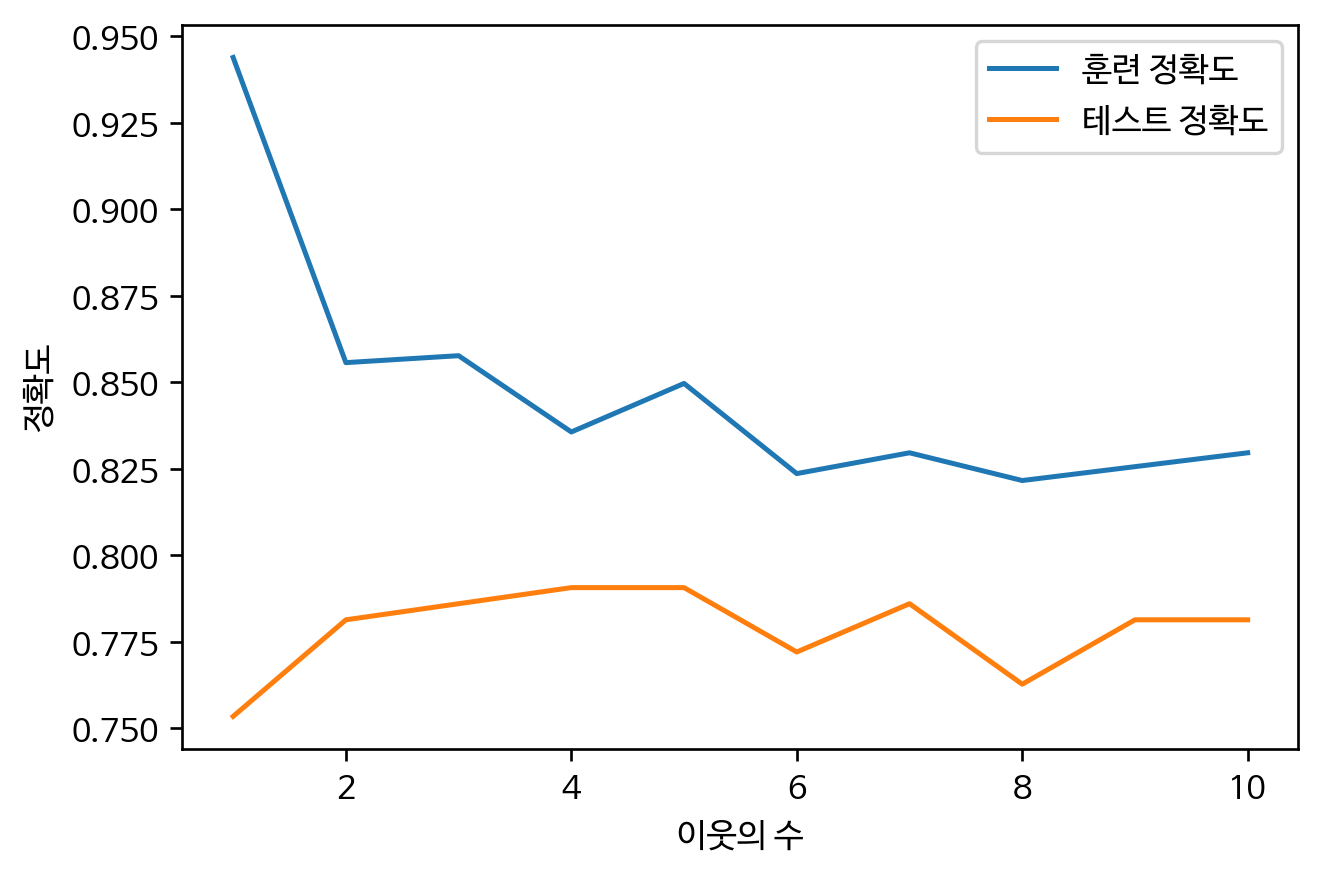

In [26]:
# 이웃의 수에 따른 정확도 저장할 리스트 변수
train_accuracy = []
test_accuracy = []

# 1에서 10까지 n_neighbors를 적용
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:

  # 모델 생성
  clf = KNeighborsClassifier(n_neighbors)
  clf.fit(X_train, y_train)

  # 훈련 세트 정확도 저장
  train_accuracy.append(clf.score(X_train, y_train))

  # 테스트 세트 정확도 저장
  test_accuracy.append(clf.score(X_test, y_test))

# 훈련 vs 테스트 정확도 시각화
plt.figure(dpi = 120)
plt.rc('font', family='NanumBarunGothic')

plt.plot(neighbors_settings, train_accuracy, label = '훈련 정확도')
plt.plot(neighbors_settings, test_accuracy, label = '테스트 정확도')
plt.ylabel('정확도')
plt.xlabel('이웃의 수')
plt.legend()
plt.show()    # 테스트 정확도가 높은 5를 골라라